## Work
請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [19]:
import os
import keras
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten
from keras.layers import Dropout, BatchNormalization, Activation
from keras.utils import to_categorical
from keras.regularizers import l1, l2

import itertools
# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [3]:
train, test = cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [6]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train, flatten=False)
x_test = preproc_x(x_test, flatten=False)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [13]:
img_shape = x_train.shape[1:]

In [27]:
x1 = range(10)
x2 = range(10, 20)
for ind, i in zip(enumerate(x1), x2):
    print(ind, i)

(0, 0) 10
(1, 1) 11
(2, 2) 12
(3, 3) 13
(4, 4) 14
(5, 5) 15
(6, 6) 16
(7, 7) 17
(8, 8) 18
(9, 9) 19


In [33]:
# Hint 1 : 在 Dense 層中增加 Regularizers
# Hint 2 : 增加 Dropout 層並設定 dropout ratio 
# Hint 3 : 增加 Batch-normalization 層
def build_cnn(input_shape, dense_neuron, drop_rate, output_shape):
    input_layer = Input(shape=input_shape)
    conv = Conv2D(filters=64, kernel_size=(3, 3), padding='same')(input_layer)
    maxpool = MaxPool2D()(conv)
    conv = Conv2D(filters=32, kernel_size=(3, 3), padding='same')(maxpool)
    maxpool = MaxPool2D()(conv)
    flatten_layer = Flatten()(maxpool)
    
    for tup, rate in zip(enumerate(dense_neuron), drop_rate):
        ind, num = tup
        if ind == 0:
            dense_layer = Dense(units=num, kernel_regularizer=l2(), activation='relu')(flatten_layer)
            drop_layer = Dropout(rate)(dense_layer)
        else:
            dense_layer = Dense(units=num, kernel_regularizer=l2(), activation='relu')(drop_layer)
            drop_layer = Dropout(rate)(dense_layer)
    
    output = Dense(units=output_shape, activation='softmax')(drop_layer)
    model = Model(inputs=[input_layer], outputs=[output])
    
    return model

def build_bn_cnn(input_shape, dense_neuron, output_shape):
    input_layer = Input(shape=input_shape)
    conv = Conv2D(filters=64, kernel_size=(3, 3), padding='same')(input_layer)
    maxpool = MaxPool2D()(conv)
    conv = Conv2D(filters=32, kernel_size=(3, 3), padding='same')(maxpool)
    maxpool = MaxPool2D()(conv)
    flatten_layer = Flatten()(maxpool)
    
    for ind, num in enumerate(dense_neuron):
        if ind == 0:
            dense_layer = Dense(units=num)(flatten_layer)
            batch_normal = BatchNormalization()(dense_layer)
            act = Activation(activation='relu')(batch_normal)
        else:
            dense_layer = Dense(units=num, activation='relu')(act)
            batch_normal = BatchNormalization()(dense_layer)
            act = Activation(activation='relu')(batch_normal)
            
    output = Dense(units=output_shape, activation='softmax')(dense_layer)
    model = Model(inputs=[input_layer], outputs=[output])
    
    return model

model = build_bn_cnn(img_shape, [256, 128], 10)
model = build_cnn(img_shape, dense_neuron=[256, 128], drop_rate=[0.7, 0.7], output_shape=10)

In [37]:
## 超參數設定
LEARNING_RATE = 1e-4
EPOCHS = 5
BATCH_SIZE = 256
INPUT_SHPAE = img_shape
OUTPUT_SHAPE = 10
DENSE_NEURON = [256, 128]
DROPOUT_RATE = [0.7, 0.7]
model_option = {'BN_CNN': build_bn_cnn, 'REGULAR_CNN': build_cnn}

model_parameters = {
    'BN_CNN': {'input_shape': INPUT_SHPAE,
               'dense_neuron': DENSE_NEURON,
               'output_shape': OUTPUT_SHAPE
              },      
    'REGULAR_CNN': {'input_shape': INPUT_SHPAE,
                    'dense_neuron': DENSE_NEURON,
                    'drop_rate': DROPOUT_RATE,
                    'output_shape': OUTPUT_SHAPE
                   }
}

In [40]:
results = {}
for name, m in model_option.items():
    parameters = model_parameters[name]
    model = m(**parameters)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(x_train, y_train, batch_size=BATCH_SIZE,
              epochs=EPOCHS, validation_data=(x_test, y_test), shuffle=True)
    
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    results[name] = {
        'train_loss': train_loss, 
        'valid_loss': valid_loss,
        'train_acc': train_acc,
        'valid_acc': valid_acc
    }

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 59s 1ms/step - loss: 1.3204 - acc: 0.5330 - val_loss: 2.2188 - val_acc: 0.3720
Epoch 2/5
50000/50000 [==============================] - 57s 1ms/step - loss: 0.9178 - acc: 0.6808 - val_loss: 1.2256 - val_acc: 0.5809
Epoch 3/5
50000/50000 [==============================] - 55s 1ms/step - loss: 0.7474 - acc: 0.7397 - val_loss: 2.7618 - val_acc: 0.3615
Epoch 4/5
50000/50000 [==============================] - 55s 1ms/step - loss: 0.6094 - acc: 0.7906 - val_loss: 1.1642 - val_acc: 0.6268
Epoch 5/5
50000/50000 [==============================] - 58s 1ms/step - loss: 0.4935 - acc: 0.8302 - val_loss: 1.0229 - val_acc: 0.6683
Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 58s 1ms/step - loss: 3.0332 - acc: 0.2629 - val_loss: 1.8465 - val_acc: 0.4289
Epoch 2/5
50000/50000 [==============================] - 56s 1ms/step - loss: 1.9206

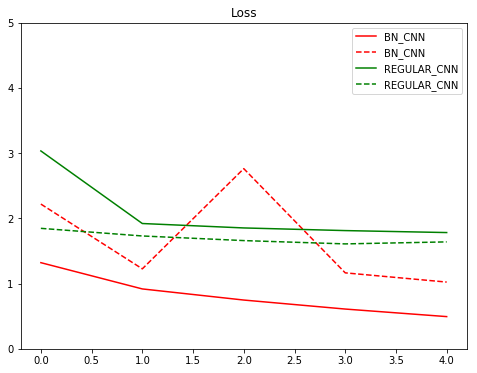

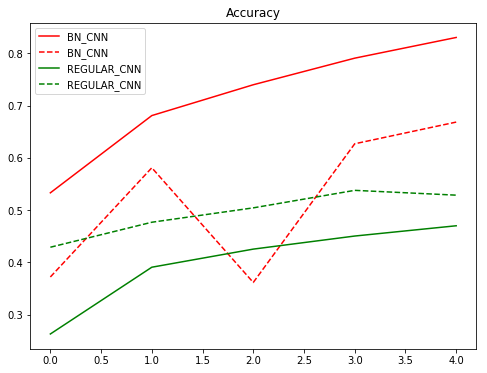

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_loss'])),results[cond]['train_loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_loss'])),results[cond]['valid_loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_acc'])),results[cond]['train_acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_acc'])),results[cond]['valid_acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()